## Skin Segmentation: A Study on Classification Using K-Nearest Neighbors And Decision Trees

The purpose of this notebook is to present a simple application of 2 popular classification methods, namely:

* K-Nearest Neighbor
* Decision Trees

The data set comes from the *University of California Irvine - Machine Learning Repository* and can be downloaded at [this link](https://archive.ics.uci.edu/ml/machine-learning-databases/00229). The dataset has 3 different features, each one being the classical Red, Green and Blue component of a color and a categorical variable which tells if this is a skin tone or not. The total length of the dataset is 245057 observations ans, as we will see, is heavily unbalanced.

As usual, the work will be organized around data pre-processing, exploration and some cross validation.

## I - K-Nearest Neighbors

### 1- Preliminary Work:

This part focuses on library loading and data pre-processseing.

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
from random import sample
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import f_oneway
from sklearn.cross_validation import train_test_split
from sklearn import feature_selection, metrics, tree
from sklearn.neighbors import KNeighborsClassifier as KNN

# Define global options
%matplotlib inline
sns.set_context(context = 'talk')
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 20)
filterwarnings('ignore')

E:\Anaconda3\envs\CourseraML\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The dataset is a tab-separated values file, proper separator must be defined in the `read_csv()` function call. The 3 features are ordered as B, G and R respectively for Blue, Green and Red (though this may be strange as the standard order is usually RGB, some computer vision libraries, such as `openCV` actually use the BGR format for color representation).

The last column, `Skin`, contains the categorical values.

In [3]:
dt = pd.read_csv('Data/Skin_NonSkin.csv', sep = '\t', names = ['B', 'G', 'R', 'Skin'])
print('Number of observations: {}'.format(len(dt.index)))
dt.head()

Number of observations: 245057


,B,G,R,Skin
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


In [4]:
dt.Skin.value_counts()

2    194198
1     50859
Name: Skin, dtype: int64

BGR values are integers scaled from 0 to 255 (please note `matplotlib` is not able to deal with colors in integer format; they have to be either converted to hexadecimal or normalized by dividing them by 255).

The categorical values are:

* `1` $\Rightarrow$ Skin
* `2` $\Rightarrow$ Non-Skin

This may be a bit confusing. Our first task will be to reorder to columns from BGR to RGB and change the categorical values such as `0` becomes `Non-Skin`.

In [5]:
dt.Skin.replace({2:0}, inplace = True)
dt = dt[['R', 'G', 'B', 'Skin']]
dt['SLabels'] = dt.Skin.replace({0: 'noskin', 1: 'skin'}, inplace = False)
dt.head(10)

,R,G,B,Skin,SLabels
0,123,85,74,1,skin
1,122,84,73,1,skin
2,121,83,72,1,skin
3,119,81,70,1,skin
4,119,81,70,1,skin
5,118,80,69,1,skin
6,119,81,70,1,skin
7,119,81,70,1,skin
8,125,87,76,1,skin
9,125,87,76,1,skin


### 2- Data Exploration:

This part focuses on getting some sense from the data (especially through plots).

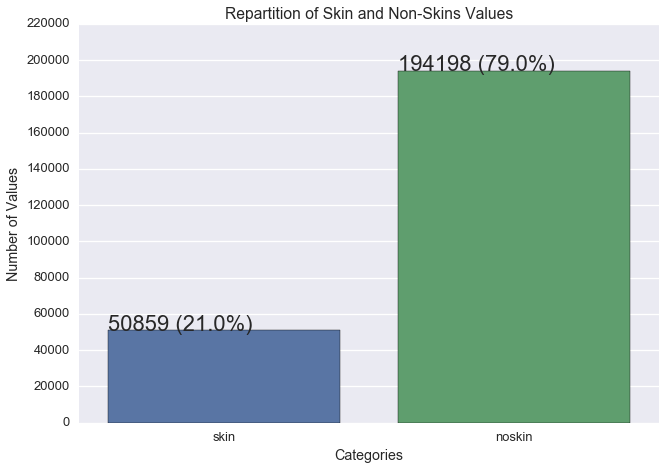

In [6]:
def plotHistogram():
    total = dt['SLabels'].value_counts().sum()
    g = sns.countplot(x = 'SLabels', data = dt)
    g.set_title('Repartition of Skin and Non-Skins Values')
    g.set_yticks(np.arange(0, 230000, 20000))
    g.set(ylabel = 'Number of Values', xlabel = 'Categories')
    for p in g.patches:
        g.text(p.get_x(), p.get_height(),
               '{} ({}%)'.format(int(p.get_height()), np.round(p.get_height()/total*100)),
               fontsize = 22)

plotHistogram()

As said before, we have a huge imbalance in the data, with the Non-Skin values representing almost 80% of the observations. In order to get reliable results in classification, we may have to balance our training dataset so that the number of Skin and Non-Skin values are equivalent...

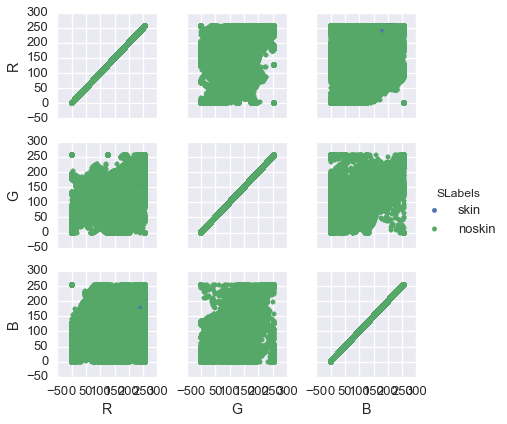

In [7]:
def displayPairPlot():
    g = sns.PairGrid(dt, hue = 'SLabels' , vars = ['R', 'G', 'B'], aspect = 1, size = 2.0)
    g.map(plt.scatter)
    g.add_legend()

displayPairPlot()

Pretty difficult to distinguish something on the pairplot (actually, it looks like earlier versions of `seaborn` does a better job at this).

All right, let's explore the color space and see how the colors are organized in the 3-dimensional RGB space. First, let's visualize the nuances of skin tones.

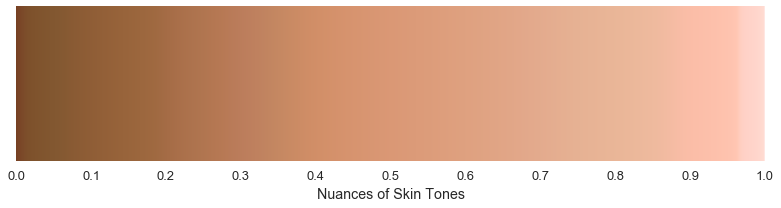

In [8]:
def displaySkinTones():
    colors_to_map = dt[dt['Skin'] == 1].loc[:,'R':'B'].apply(lambda x: x/255.0, axis = 0).values
    colors_to_map.sort(axis = 0)
    cmap = mpl.colors.ListedColormap(colors_to_map)
    norm = mpl.colors.Normalize(vmin = 0.0, vmax = 1.0)
    # NOTA: parameters of add_axes() are respectively: left, bottom, wide, height
    g = mpl.colorbar.ColorbarBase(plt.figure().add_axes([0.0, 1.0, 1.0, 0.3]), norm = norm,
                                  cmap = cmap, orientation = 'horizontal')
    g.set_label('Nuances of Skin Tones');
    
displaySkinTones()

Display the whole dataset in a 3D plot:

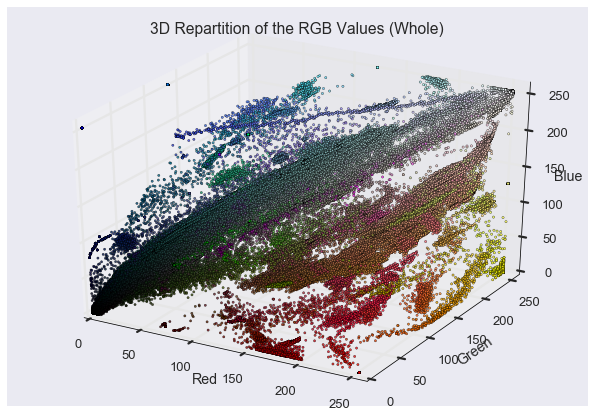

In [9]:
def displayScatter3DWhole():
    colors = dt.loc[:, 'R':'B'].apply(lambda x: x/255.0).values
    ax = plt.figure().add_subplot(111, projection = '3d')
    ax.scatter(dt.loc[:,'R'],
               dt.loc[:,'G'],
               dt.loc[:,'B'],
               alpha = 0.8, c = colors, s = 5);
    ax.set_title('3D Repartition of the RGB Values (Whole)')
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_xlim(0, 260)
    ax.set_ylim(0, 260)
    ax.set_zlim(0, 260);

displayScatter3DWhole()

Then distinguish between the non-skin and skin values:

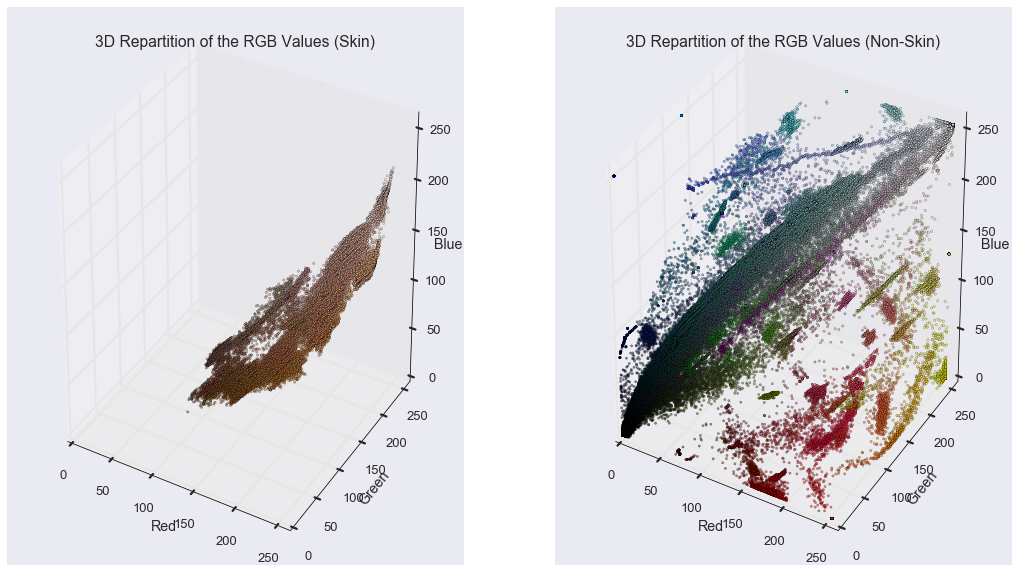

In [10]:
def displayScatter3D():
    dt_skin = dt[dt['Skin'] == 1].loc[:,'R':'B']
    dt_nskin = dt[dt['Skin'] == 0].loc[:,'R':'B']
    colors_skin = dt_skin.apply(lambda x: x/255.0).values
    colors_nskin = dt_nskin.apply(lambda x: x/255.0).values
    fig = plt.figure(1, figsize = (18, 10))
    ax1 = fig.add_subplot(121, projection = '3d')
    ax1.scatter(dt_skin['R'].values,
                dt_skin['G'].values,
                dt_skin['B'].values,
                alpha = 0.5, c = colors_skin, s = 5);
    ax1.set_title('3D Repartition of the RGB Values (Skin)')
    ax1.set_xlabel('Red')
    ax1.set_ylabel('Green')
    ax1.set_zlabel('Blue')
    ax1.set_xlim(0, 260)
    ax1.set_ylim(0, 260)
    ax1.set_zlim(0, 260);
    
    ax2 = fig.add_subplot(122, projection = '3d')
    ax2.scatter(dt_nskin['R'].values,
                dt_nskin['G'].values,
                dt_nskin['B'].values,
                alpha = 0.5, c = colors_nskin, s = 5)
    ax2.set_title('3D Repartition of the RGB Values (Non-Skin)')
    ax2.set_xlabel('Red')
    ax2.set_ylabel('Green')
    ax2.set_zlabel('Blue')
    ax2.set_xlim(0, 260)
    ax2.set_ylim(0, 260)
    ax2.set_zlim(0, 260);

displayScatter3D()

Even though the skin tones seem to form like a cluster, the limits are kind of fuzzy. 3D plots tend to have limits when it comes to visualization as the angle makes it sometimes hard to precisely locate the values of interest.

Adding some computations may clarify this:

In [11]:
def displayMeanStd():
    dat = dt[dt['Skin'] == 1].loc[:, 'R':'B']
    for col in dat.columns:
        mean = dat[col].mean()
        std = dat[col].std()
        print('For primary color {} => mean is {:.2f} / standard deviation is {:.2f}'.format(col, mean, std))

displayMeanStd()

For primary color R => mean is 203.99 / standard deviation is 37.70
For primary color G => mean is 146.60 / standard deviation is 35.84
For primary color B => mean is 113.87 / standard deviation is 41.61


It appears the skin tones have little deviations from their means with respect to the 3 color components, the biggest deviation being for the Blue,  the smallest for the green.

### 3- Cross Validation:

The purpose here is to take all 3 features and determine the best `k` through an iterative process. We will define again some helper functions for that, however, to keep the running time as reasonnable as possible, we strongly recommend to limit the maximum number `k`. A maximum of 100 with an increment of 2 seems reasonnable.

The following helper function creates both training and testing data sets and keeps the training data set balanced. Please note it is not necessary to balance the testing data (and it is actually not recommended).

The splitting between training and testing will be as following:

* 80% as training data
* 20% as testing data

In [12]:
def balanceSetSplit(dataset, features, target, split_ratio):
    # 1. Gather the indexes for training and testing with respect to a splitting ratio
    train_idx = sample(dataset.index, int(split_ratio * len(dataset)))
    test_idx = dataset.index.difference(train_idx)
    train_base = dataset.ix[train_idx, :]
    
    # 2. Create the testing dataset; if there is only 1 feature, change the shape of the array to a column vector
    X_test = dataset.ix[test_idx, features].values
    y_test = dataset.ix[test_idx, target].values.ravel()
    if X_test.ndim == 1:
        X_test = X_test.reshape(-1,1)
    
    # 3. Inside the training data set, determine which of the categorical value is the least represented
    min_val = np.min(pd.Series(train_base[target]).value_counts().values)
    
    # 4. For each of the categorical values, take a sample of the matching indexes and append the correspondig rows
    #    to a new dataframe; some acrobatics needed to convert the array obtained to a set
    train_set = pd.DataFrame()
    for tg in set(train_base[target].values.ravel()):
        temp_idx = sample(train_base[train_base[target] == tg].index, min_val)
        train_set = train_set.append(train_base.ix[temp_idx, :])
    
    # 5. Create the training dataset from the new dataframe previously created; same remark as for the testing data set
    #    if there is only 1 feature
    X_train = train_set.loc[:, features].values
    y_train = train_set.loc[:, target].values.ravel()
    if X_train.ndim == 1:
        X_train = X_train.reshape(-1,1)
    
    # NOTA: unfortunately, the sample function does not allow to set the seed, which slightly hampers reproducibility.
    return X_train, X_test, y_train, y_test

Let's see how the scores of the k-nearest neighbor classification evolves with the number of neighbors; the first run will try all k values from 1 to 99, with an increment of 2.

In [13]:
def crossValidationManiac(n = 100):
    X_train, X_test, y_train, y_test = balanceSetSplit(dt, ['R', 'G', 'B'], ['Skin'], 0.8)
    n_neigh = range(1, n, 2)
    scores = list()
    for k in n_neigh:
        clf_model = KNN(k)
        clf_model.fit(X_train, y_train)
        scores.append(clf_model.score(X_test, y_test))
    plt.figure(figsize=(20,8))
    plt.plot(n_neigh, scores, linewidth=3.0);
    plt.xticks(n_neigh)
    plt.title('Classification Scores (max K = {})'.format(n))
    plt.xlabel('Value of K')
    plt.ylabel('Scores')

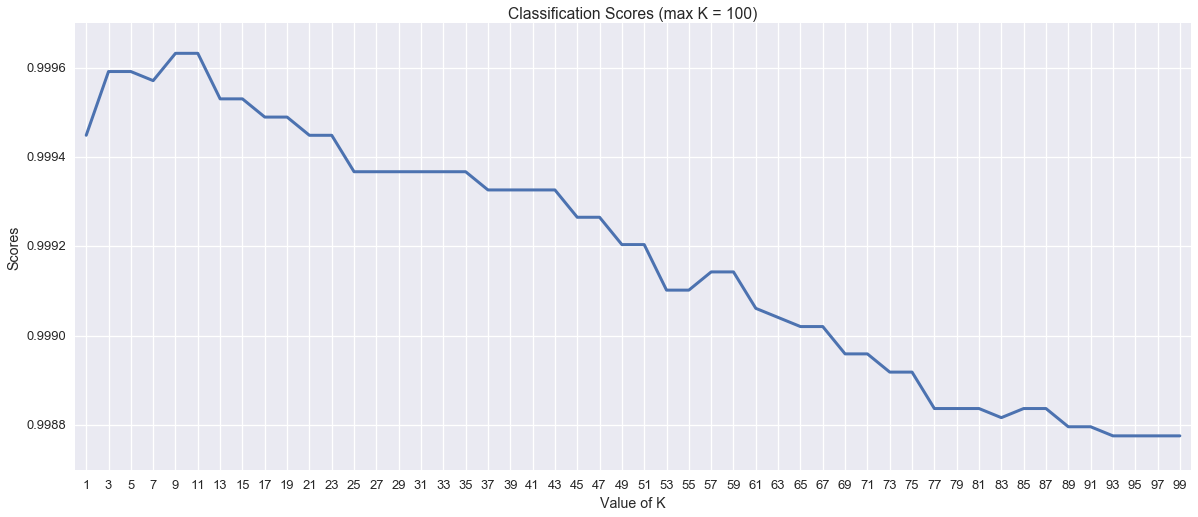

In [14]:
crossValidationManiac()

Apparently, high values of k may not have such a positive influence on the classification score. Let's limit the highest number of neighbors to `40`.

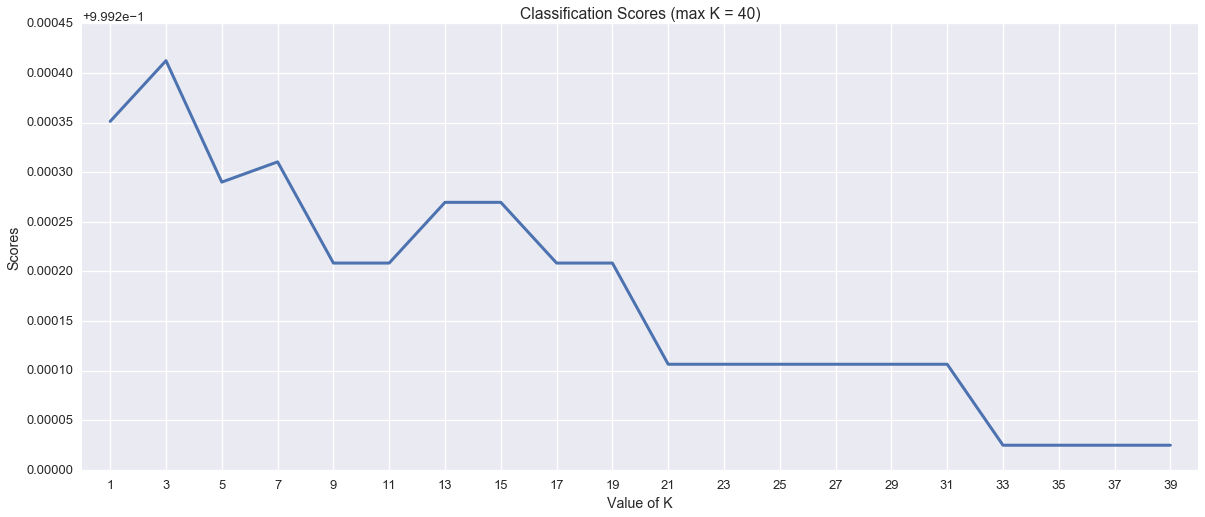

In [15]:
crossValidationManiac(40)

In both cases, the score drops drastically for high values of K. We may limit this value even more, however there are some fluctuations. So we have to perform an iterative validation to see how the scores are stable for different values of K.

We will limit the highest value of K to 25 and try as much iterations as possible (the time may vary from machine to machine but higher than 100 iterations may necessite several hours to complete; here for practicality, we limit ourselves to 20 iterations).

In [16]:
def crossValidationBerserk(itr = 5):
    n_neigh = range(1, 27, 2)
    scores = defaultdict(list)
    for i in range(itr):
        X_train, X_test, y_train, y_test = balanceSetSplit(dt, ['R', 'G', 'B'], ['Skin'], 0.8)
        for kval in n_neigh:
            clf_model = KNN(kval)
            clf_model.fit(X_train, y_train)
            scores[kval].append(clf_model.score(X_test, y_test))
    scores = [np.mean(scores[k]) for k in scores]
    plt.figure(figsize = (20, 8))
    plt.plot(n_neigh, scores, linewidth=3.0);
    plt.xticks(n_neigh)
    plt.title('Classification Scores Over Iterrations (iterations = {})'.format(itr))
    plt.xlabel('Value of K')
    plt.ylabel('Scores')

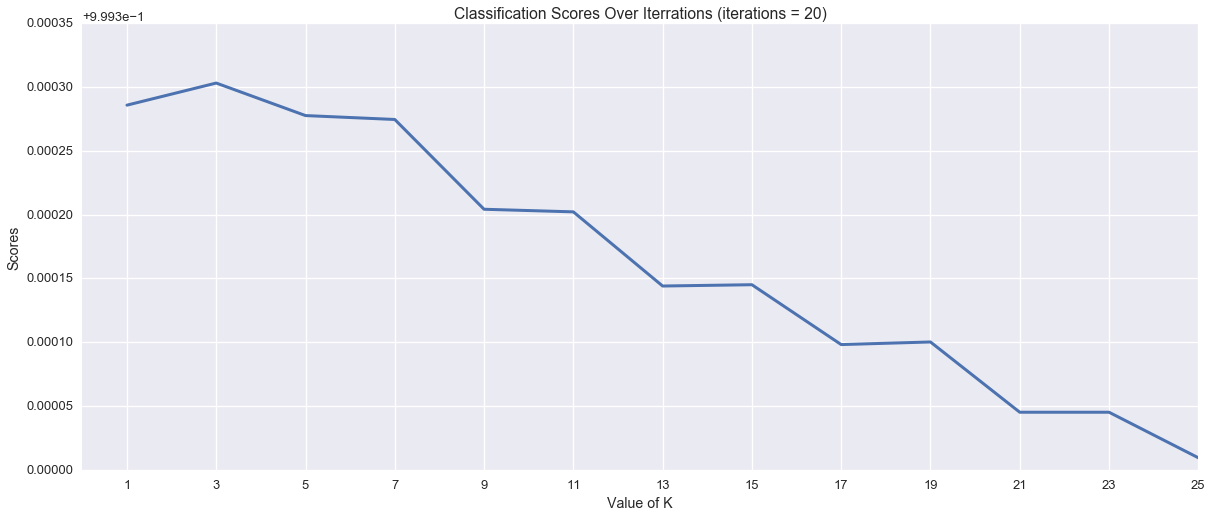

In [17]:
crossValidationBerserk(20)

Through 20 iterations, the higher scores are for `K=1` or `K=3`; please note this may vary with the number of iterations. More iterations may lead to a smoother curve and more reliable results (on another machine I was able to run a 100 iterations and still got `K=1` has the best value).

_NOTA: the default value of K for k-nearrest neighbors is 5_

### 4- Model Comparison:

Here, we will perform a quick comparison between some values of K:

In [18]:
def knnComparison(k):
    X_train, X_test, y_train, y_test = balanceSetSplit(dt, ['R', 'G', 'B'], ['Skin'], 0.8)
    for val in k:
        clf = KNN(val)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        print('For K = {}'.format(val))
        print('Score = {:.6f}'.format(clf.score(X_test, y_test)))
        print('Confusion Matrix:\n{}'.format(metrics.confusion_matrix(y_test, predictions)))
    
knnComparison([1, 3, 5])

For K = 1
Score = 0.999592
Confusion Matrix:
[[38967    15]
 [    5 10025]]
For K = 3
Score = 0.999531
Confusion Matrix:
[[38967    15]
 [    8 10022]]
For K = 5
Score = 0.999572
Confusion Matrix:
[[38965    17]
 [    4 10026]]


Apparently, `K=1` performs better. Let's have a look at the precision/recall curve:

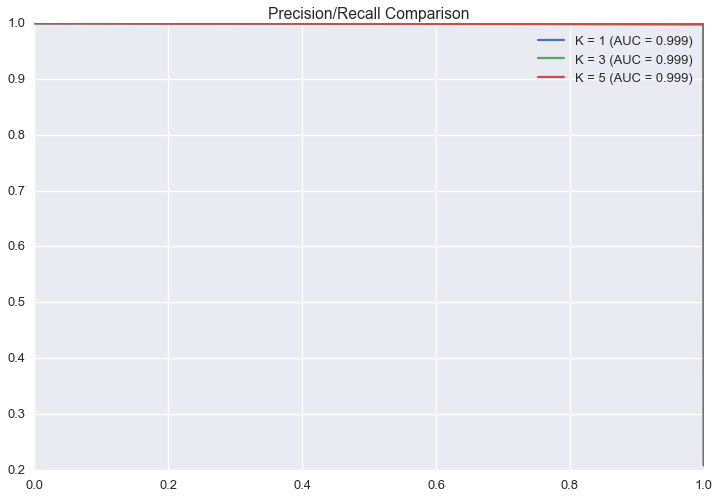

In [19]:
def knnPrecRec(k):
    X_train, X_test, y_train, y_test = balanceSetSplit(dt, ['R', 'G', 'B'], ['Skin'], 0.8)
    plt.figure(1, figsize = (12, 8))
    for val in k:
        clf = KNN(val)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        prec, recl, thres = metrics.precision_recall_curve(y_test, predictions)
        area  = metrics.auc(recl, prec)
        plt.plot(recl, prec, label = 'K = {} (AUC = {:.3f})'.format(val, area))
    plt.title('Precision/Recall Comparison')
    plt.legend()

knnPrecRec([1, 3, 5])

Comparing the precision/recall curves does not bring much more information.

### 4- Plotting Decision Boundaries

Now, we will try to plot the decision boundaries. However, as we will plot them in a 2D space, we can only choose 2 features for the x/y axis. Let's choose the most important ones:

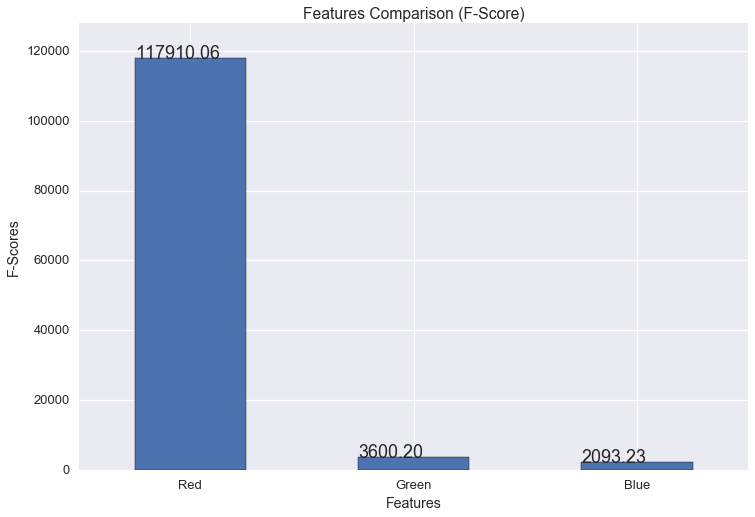

In [20]:
def checkFeatures():
    X = dt.ix[:,'R':'B']
    y = dt.ix[:, 'Skin']
    F = feature_selection.f_classif(X, y)[0]
    fig = plt.figure(1, figsize = (12, 8))
    ax = plt.bar(np.arange(3), F, width = 0.5, tick_label = ('Red', 'Green', 'Blue'), align = 'center')
    for p in ax.patches:
         plt.text(p.get_x(), p.get_height(), '{:.2f}'.format(p.get_height()), fontsize = 18)
    plt.title('Features Comparison (F-Score)')
    plt.xlabel('Features')
    plt.ylabel('F-Scores')
    plt.ylim(ymax = np.max(F) + 10000)
    
checkFeatures()

As we can see, the Red feature is overwhelmingly important with respect to the 2 other ones. Green and Blue are much lower, even though Green is about twice as much as Blue.

For our meshgrid, we will consider only the Red and Green colors.

_NOTA: a useful resource for [Hexadecimal Color Values](http://cloford.com/resources/colours/500col.htm)._

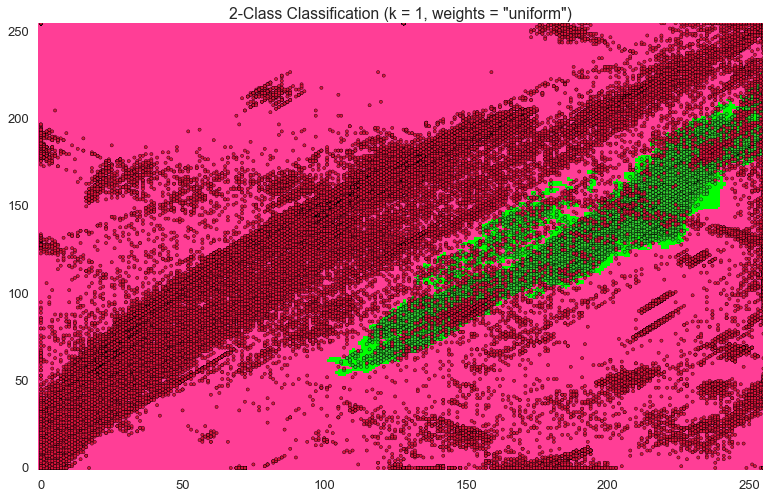

In [21]:
def plotMeshGrid():
    cmap_light = mpl.colors.ListedColormap(['#FF3E96', '#00FF00'])
    cmap_bold = mpl.colors.ListedColormap(['#DC143C', '#32CD32'])
    X_total = dt.ix[:, 'R':'G'].values
    y_total = dt.ix[:, 'Skin'].values
    clf = KNN(1, weights = 'uniform')
    clf.fit(X_total, y_total)
    mesh_step = 1.0
    x_min, x_max = X_total[:, 0].min() - 1, X_total[:, 0].max() + 1
    y_min, y_max = X_total[:, 1].min() - 1, X_total[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step), np.arange(y_min, y_max, mesh_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize = (13, 8))
    plt.pcolormesh(xx, yy, Z, cmap = cmap_light)
    plt.scatter(X_total[:, 0], X_total[:, 1], c = y_total, cmap = cmap_bold, s = 10)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title('2-Class Classification (k = {}, weights = "{}")'.format(1, 'uniform'));

plotMeshGrid()

### 5- Conclusion:

This part is a short introduction on how to use k-nearest neighbors for classification problems. Though it is a starightforward algorithm, it is also quite demanding in terms of computation. The dataset used here compiled more than 200000 observations and the cross-validation step was excruciatingly long, even with a number of iterations as low as 20 (a real cross-validation should consider at least several hundreds of iterations).

Here, we found that if we consider all three features, the best value of k is 1. However, we also noticed that the Red feature is incredibly important with respect to the other 2. An interesting work would be to simplify the model by taking only the Red and Green color and rerun the cross-validation step to get the optimized value of k, then compare which one of the 2 models performs better.

## II - Decision Trees

### 1- Overview:

In this part, we will have a short look on how to manipulate decision tree-based models. Decision trees are flowchart-like structures in which each internal node represents a test of an attribute, each branch represents an outcome of said test and each leaf node represents a class label. Decision tress have the following characteristics:

* __Non-Parametric:__ No parameters, no distribution assumptions.
* __Hierarchical:__ Consists in a sequence of questions, which yields a class label when applied to any record.
* __Variable Size:__ Any boolean functions can be represented.
* __Deterministic:__ For the same set of features, the tree will assign the same label.

Decision trees support for both *discrete* and *continuous* parameters (binning and thresholds).

First, let's have a look on how decision trees perform: 

In [22]:
def basicModel(depth = None, split = 2, leaves = 1, mode = ''):
    X_train, X_test, y_train, y_test = balanceSetSplit(dt, ['R', 'G', 'B'], ['Skin'], 0.8)
    clf = tree.DecisionTreeClassifier()
    clf.set_params(max_depth = depth, min_samples_split = split, min_samples_leaf = leaves)
    clf.fit(X_train, y_train)
    if mode == 'verbose':
        if not depth:
            dp = 0
        else:
            dp = depth
        print('Score = {:.6f} (max-depth = {:<3} | min-samples-leaf = {:<3})'.format(clf.score(X_test, y_test),
                                                                                     dp, leaves))
        print('Confusion Matrix:\n{}'.format(metrics.confusion_matrix(y_test, clf.predict(X_test))))
    else:
        return clf.score(X_test, y_test)

In [23]:
basicModel(mode = 'verbose')

Score = 0.999041 (max-depth = 0   | min-samples-leaf = 1  )
Confusion Matrix:
[[38942    30]
 [   17 10023]]


The score is pretty good, but still, we have 30 mislabelled non-skin and 17 mis-labelled skin. There are ways to generalize the tree in `scikit-learn`, mainly by modifying the following parameters:

* __`max_depth` :__ This is the maximum depth of the tree. if `None`, the nodes are expanded until all leaves are pure or until all leaves contain less then min_samples_split (default = `None`).
* __`min_samples_leaf` :__ The minimum number of samples to be at a leaf node (default = 1).
* __`min_samples_split` :__ The minimum number of samples required to split an internal node (default = 2).

The concept of **purity** is very important when we are talking about trees. Purity is a measure of how much one node consists entirely of members of a single class. For example:

* A node having 2 members of one class and 0 members of another class has the highest purity (respectively 0 impurity).
* A node having 1 memeber of one class and 1 memeber of another has 0 purity (respectively the highest impurity).

When it comes to determine purity, we are actually considering the inverse concept, namely the **impurity**. There are 3 different common measures of impurity, all using the quantities $p(i \mid t)$, denoting the fraction of records that belong to class $i$ at a given node $t$, and $c$ which is the number of classes:

* _entropy_ : $$entropy(t) = - \sum_{i=0}^{c} p(i \mid t) . \log_2 p(i \mid t)$$
* _gini impurity_ : $$gini(t) = 1 - \sum_{i=0}^{c} \left[ p(i \mid t) \right]^2$$
* _classification error_ : $$classError(t) = 1 - \max_i \left[ p(i \mid t) \right]$$

Let's see how the score evolves with the `max_depth`:

In [24]:
def plotTreeScores(d, param = 'depth'):
    scores = []
    rng = np.arange(d[0], d[1] + 1, 1)
    for val in rng:
        if param == 'depth':
            scores.append(basicModel(depth = val))
        elif param == 'leaves':
            scores.append(basicModel(leaves = val))
    plt.figure(figsize = (20, 8))
    plt.plot(rng, scores, linewidth=3.0);
    plt.ylabel('Scores')
    if param == 'depth':
        plt.title('Scores Variation With Maximum Depth')
        plt.xlabel('Max-depth')
    elif param == 'leaves':
        plt.title('Scores Variation With Minimum Samples per Leaves')
        plt.xlabel('Minimum Samples per Leaves')

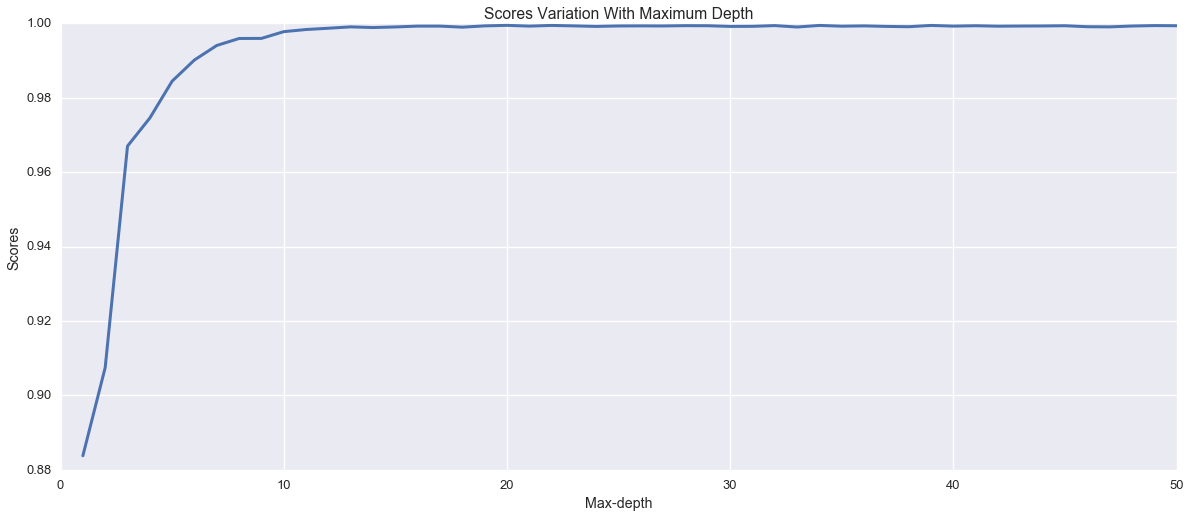

In [25]:
plotTreeScores((1, 50), param = 'depth')

Interesting... Let's have a better view of what happens for `max_depth > 10`:

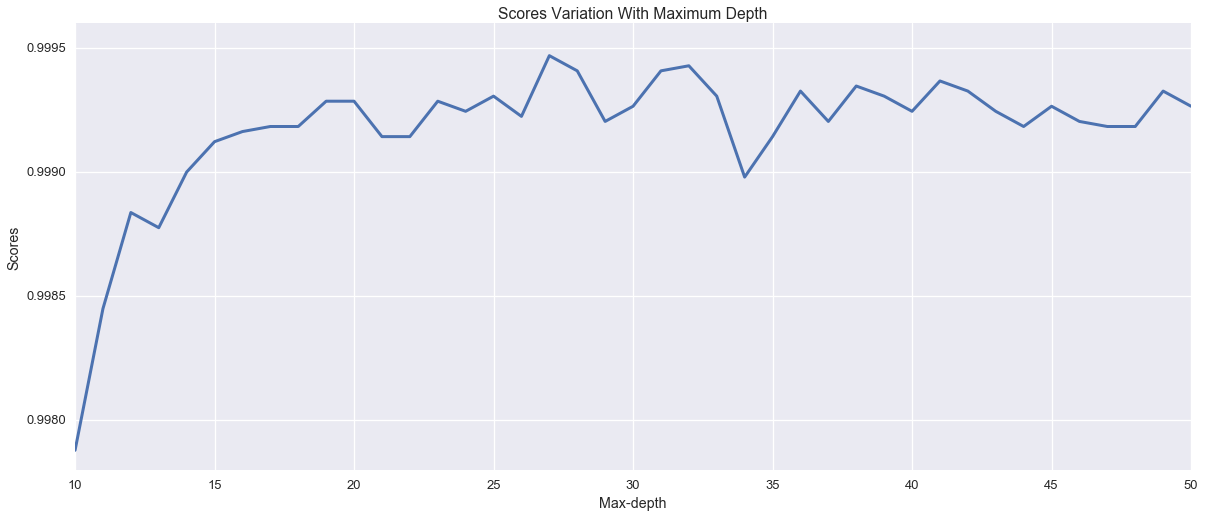

In [26]:
plotTreeScores((10, 50), param = 'depth')

It looks like we can ensure a score between 0.9990 and 0.9995 if we choose a maximum depth of at least 20.

How the minimum number of sample per leaves affect the results?

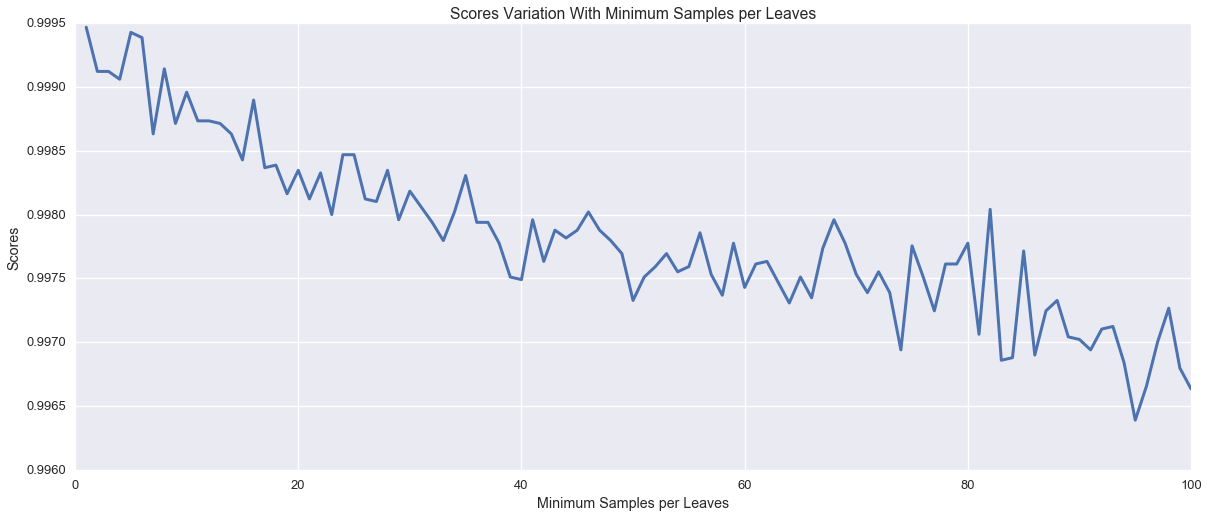

In [27]:
plotTreeScores((1, 100), param = 'leaves')

Contrary to the maximum depth, it looks like the score decreases with the minimum number of samples per leaves:

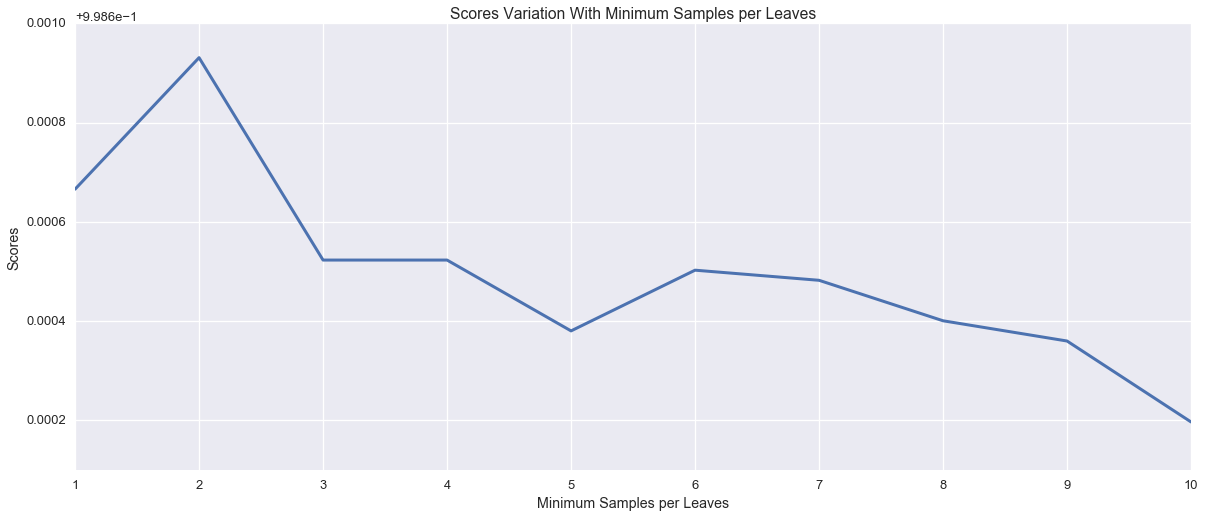

In [28]:
plotTreeScores((1, 10), param = 'leaves')

Apparently, we may get better values for a minimum number of samples per leaves around 2 (for the record, the default value is 1)...

### 2- Cross Validation:

We should probably try a manner of cross validation similar to the one we performed for k-nearest neighbors, in order to find the best maximum depth for our tree:

In [29]:
def treeCrossValidation(itr):
    depth = range(20, 50, 1)
    scores = defaultdict(list)
    for i in range(itr):
        X_train, X_test, y_train, y_test = balanceSetSplit(dt, ['R', 'G', 'B'], ['Skin'], 0.8)
        for d in depth:
            clf = tree.DecisionTreeClassifier(max_depth = d, min_samples_leaf = 2)
            clf.fit(X_train, y_train)
            scores[d].append(clf.score(X_test, y_test))
    scores = [np.mean(scores[k]) for k in scores]
    plt.figure(figsize = (20, 8))
    plt.plot(depth, scores, linewidth=3.0);
    plt.xticks(depth)
    plt.title('Classification Scores Over Iterations (iterations = {})'.format(itr))
    plt.xlabel('Maximum Depth')
    plt.ylabel('Scores')

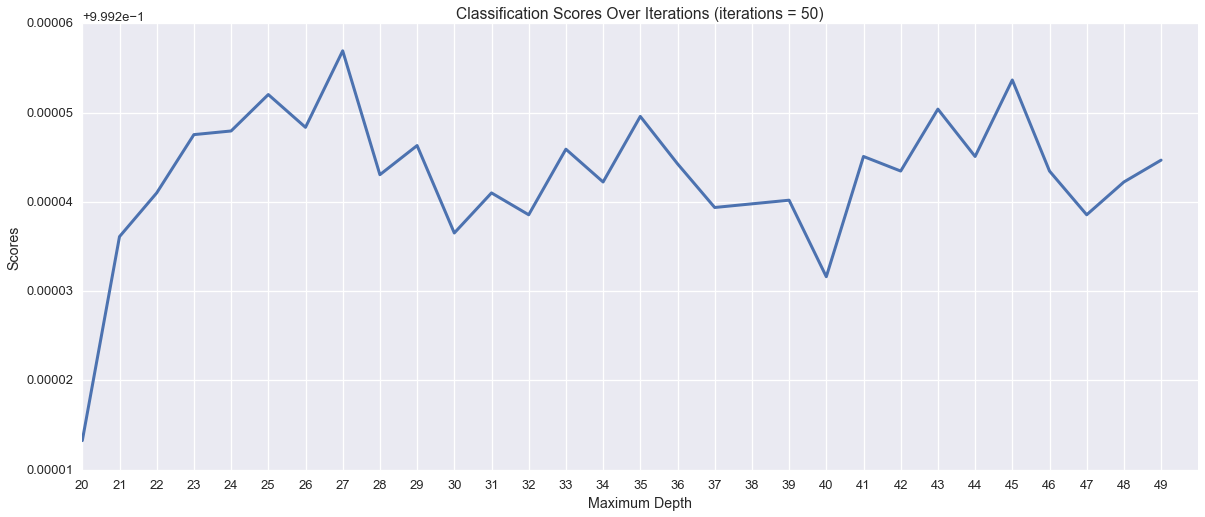

In [30]:
treeCrossValidation(50)

According to the results of our cross validation, we can expect one of the best results for a maximum depth around 27.

If we perform a final comparison:

In [31]:
basicModel(depth = 27, leaves = 2, mode = 'verbose')

Score = 0.999408 (max-depth = 27  | min-samples-leaf = 2  )
Confusion Matrix:
[[38618    12]
 [   17 10365]]


### 3- Conclusion:

In `scikit-learn`, trees are very easy to implement and to use and provide good results. Fine-tuning is slightly more difficult and requires heavy computations, though the complexity might be slightly below k-nearest neighbor's (particularly for large values of k).

_TO-DO: expand this work with an actual tree visualization (maybe with D3.js)_